Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

Model

In [2]:
nu = 1
tau = 1
tau_s = 1

def eps(s, d_ij):
    return (s - d_ij) / tau_s * np.exp(-(s - d_ij) / tau_s) * (1 if s - d_ij > 0 else 0)

def eta(s):
    return -nu * np.exp(-s / tau) * (1 if s > 0 else 0)

def is_target_spiking(output, target):
    return output[target] == 1

In [3]:
class SRM:
    def __init__(self, input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max):
        self.input_neurons = input_neurons
        self.hidden_neurons_1 = hidden_neurons_1
        self.hidden_neurons_2 = hidden_neurons_2
        self.output_neurons = output_neurons
        self.threshold = threshold
        self.t_max = t_max

        self.synapses_cnt1 = np.random.randint(low = min_synapses, high = max_synapses, size = (input_neurons, hidden_neurons_1))
        self.synapses_cnt2 = np.random.randint(low = min_synapses, high = max_synapses, size = (hidden_neurons_1, hidden_neurons_2))
        self.synapses_cnt3 = np.random.randint(low = min_synapses, high = max_synapses, size = (hidden_neurons_2, output_neurons))

        self.d1 = np.random.randint(low = 1, high = max_delay, size = (input_neurons, hidden_neurons_1))
        self.d2 = np.random.randint(low = 1, high = max_delay, size = (hidden_neurons_1, hidden_neurons_2))
        self.d3 = np.random.randint(low = 1, high = max_delay, size = (hidden_neurons_2, output_neurons))

        self.w1 = np.random.random((input_neurons, hidden_neurons_1))
        self.w2 = np.random.random((hidden_neurons_1, hidden_neurons_2))
        self.w3 = np.random.random((hidden_neurons_2, output_neurons))

        self.u1 = np.zeros((t_max, hidden_neurons_1))
        self.u2 = np.zeros((t_max, hidden_neurons_2))
        self.u3 = np.zeros((t_max, output_neurons))

        self.spikes_0 = np.zeros((t_max, input_neurons))
        self.spikes_1 = np.zeros((t_max, hidden_neurons_1))
        self.spikes_2 = np.zeros((t_max, hidden_neurons_2))
        self.spikes_3 = np.zeros((t_max, output_neurons))

        self.prev_t_0 = np.zeros(input_neurons)
        self.prev_t_1 = np.zeros(hidden_neurons_1)
        self.prev_t_2 = np.zeros(hidden_neurons_2)
        self.prev_t_3 = np.zeros(output_neurons)

        self.dts = []
        self.dws = []

        self.reward = np.ones(t_max)

    def apply(self, input_layer, t):
        for i in range(self.input_neurons):
            if input_layer[i] == 1:
                self.prev_t_0[i] = t
                self.spikes_0[t, i] = 1

        for i in range(self.hidden_neurons_1):
            self.u1[t, i] = eta(t - self.prev_t_1[i])
            for j in range(self.input_neurons):
                self.u1[t, i] += self.w1[j, i] * eps(t - self.prev_t_0[j] - self.d1[j, i], self.d1[j, i])
            if self.u1[t, i] > self.threshold:
                self.prev_t_1[i] = t
                self.spikes_1[t, i] = 1

        for i in range(self.hidden_neurons_2):
            self.u2[t, i] = eta(t - self.prev_t_2[i])
            for j in range(self.hidden_neurons_1):
                self.u2[t, i] += self.w2[j, i] * eps(t - self.prev_t_1[j] - self.d2[j, i], self.d2[j, i])
            if self.u2[t, i] > self.threshold:
                self.prev_t_2[i] = t
                self.spikes_2[t, i] = 1

        for i in range(self.output_neurons):
            self.u3[t, i] = eta(t - self.prev_t_3[i])
            for j in range(self.hidden_neurons_2):
                self.u3[t, i] += self.w3[j, i] * eps(t - self.prev_t_2[j] - self.d3[j, i], self.d3[j, i])
            if self.u3[t, i] > self.threshold:
                self.prev_t_3[i] = t
                self.spikes_3[t, i] = 1

    def STDP(self, w_min, w_max, taup, taun, nup, nun, tick):
        for i in range(self.input_neurons):
            for j in range(self.hidden_neurons_1):
                d_t = self.prev_t_1[j] - self.prev_t_0[i]
                if d_t >= 0:
                    dw = (w_max - self.w1[i, j]) * nup * np.exp(-d_t/taup)
                    self.w1[i, j] += dw * self.reward[tick]
                    self.dts.append(d_t)
                    self.dws.append(dw)
                else:
                    dw = -(self.w1[i, j] - w_min) * nun * np.exp(d_t/taun)
                    self.w1[i, j] += dw * self.reward[tick]
                    self.dts.append(d_t)
                    self.dws.append(dw)

        for i in range(self.hidden_neurons_1):
            for j in range(self.hidden_neurons_2):
                d_t = self.prev_t_2[j] - self.prev_t_1[i]
                if d_t >= 0:
                    dw = (w_max - self.w2[i, j]) * nup * np.exp(-d_t/taup)
                    self.w2[i, j] += dw * self.reward[tick]
                    self.dts.append(d_t)
                    self.dws.append(dw)                    
                else:
                    dw = -(self.w2[i, j] - w_min) * nun * np.exp(d_t/taun)
                    self.w2[i, j] += dw * self.reward[tick]
                    self.dts.append(d_t)
                    self.dws.append(dw)                    
      
        for i in range(self.hidden_neurons_2):
            for j in range(self.output_neurons):
                d_t = self.prev_t_3[j] - self.prev_t_2[i]
                if d_t >= 0:
                    dw = (w_max - self.w3[i, j]) * nup * np.exp(-d_t/taup)
                    self.w3[i, j] += dw * self.reward[tick]
                    self.dts.append(d_t)
                    self.dws.append(dw)
                else:
                    dw = -(self.w3[i, j] - w_min) * nun * np.exp(d_t/taun)
                    self.w3[i, j] += dw * self.reward[tick]
                    self.dts.append(d_t)
                    self.dws.append(dw)

    def calculate_reward(self, tick, target, base_reward, steps_to_one):
        output_spikes = self.spikes_3[tick]
        if is_target_spiking(output_spikes, target):
            self.reward[tick] = base_reward
            return
        if tick > 0 and self.reward[tick - 1] > 1.0:
            self.reward[tick] = self.reward[tick - 1] - (base_reward - 1.0) / steps_to_one

    def get_pred_label(self, t):
        output_spikes = self.spikes_3[tick]
        if np.sum(output_spikes) == 1:
            return convert_output_spikes_to_class_label(output_spikes)
        return -1

    def reset_reward(self, tick):
        self.reward[tick] = 1.0


    def visualize_simulation(self):
        time = np.arange(self.t_max)
        fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize = (20,10))

        ax1.plot(time, np.sum(self.spikes_0, axis = 1), 'g')
        ax1.set_xlabel('Time (s)')
        ax1.set_ylabel('Number of active neurons')
        ax1.set_title('Input layer')
        ax2.plot(time, np.sum(self.spikes_1, axis = 1), 'r')
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Number of active neurons')
        ax2.set_title('First hidden layer')
        ax3.plot(time, np.sum(self.spikes_2, axis = 1), 'b')
        ax3.set_xlabel('Time (s)')
        ax3.set_ylabel('Number of active neurons')
        ax3.set_title('Second hidden layer')
        ax4.plot(time, np.sum(self.spikes_3, axis = 1), 'orange')
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Number of active neurons')
        ax4.set_title('Output layer')

        ax5.plot(time, self.spikes_0[:, np.argmax(np.sum(self.spikes_0, axis = 0))], 'g')
        ax5.set_xlabel('Time (s)')
        ax5.set_ylabel('Spikes of the most active neuron')
        ax6.plot(time, self.spikes_1[:, np.argmax(np.sum(self.spikes_1, axis = 0))], 'r')
        ax6.set_xlabel('Time (s)')
        ax6.set_ylabel('Spikes of the most active neuron')
        ax7.plot(time, self.spikes_2[:, np.argmax(np.sum(self.spikes_2, axis = 0))], 'b')
        ax7.set_xlabel('Time (s)')
        ax7.set_ylabel('Spikes of the most active neuron')
        ax8.plot(time, self.spikes_3[:, np.argmax(np.sum(self.spikes_3, axis = 0))], 'orange')
        ax8.set_xlabel('Time (s)')
        ax8.set_ylabel('Spikes of the most active neuron')

        plt.show()
        plt.close()

    def visualize_learning(self): 
        dt = np.array(self.dts)
        dw = np.array(self.dws)
        fig, ax = plt.subplots()
        ax.scatter(dt, dw, s=8, c="red")
        ax.set_xlim(-50, 50)
        ax.set_ylim(-0.01, 0.01)
        ax.grid()

Spike train generator

In [4]:
def spike_train_generator(T, input_neurons, lam):
  input_pattern = np.zeros((T, input_neurons))
  for i in range(input_neurons):
    j = -1
    while j < T:
      j += np.random.poisson(lam, 1)
      if j >= T:
        break
      input_pattern[j, i] = 1
  return input_pattern

Task 1 - parameters

In [5]:
lam = 25
input_neurons = 5
hidden_neurons_1 = 10
hidden_neurons_2 = 20
output_neurons = 2
min_synapses = 3
max_synapses = 7
max_delay = 7
threshold = 0.3
epochs = 5
T = 100
t_max = epochs * T

Simulation 1

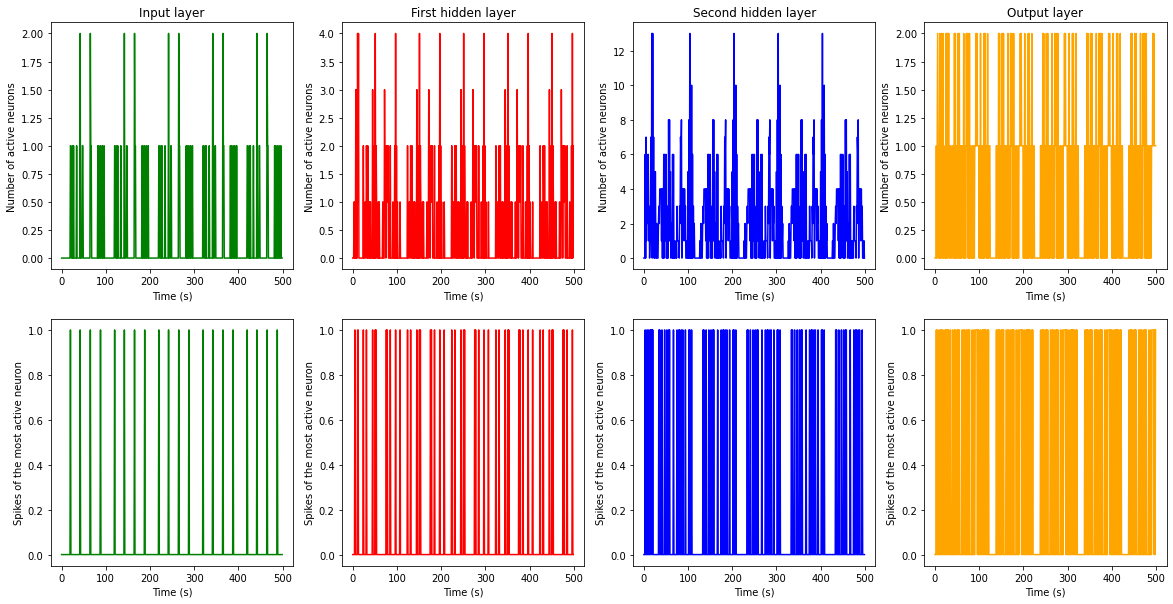

In [6]:
input_pattern1 = spike_train_generator(T, input_neurons, lam)

model1 = SRM(input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max)
for epoch in range(epochs):
  for tick in range(T):
    model1.apply(input_pattern1[tick], epoch * T + tick)

model1.visualize_simulation()

Simulation 2

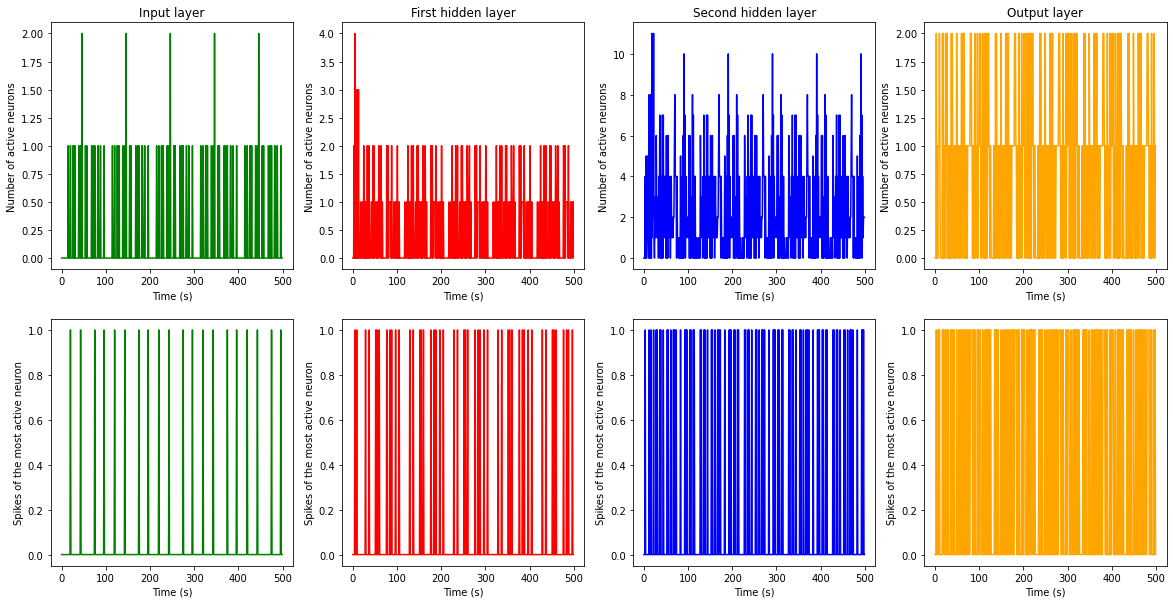

In [7]:
input_pattern2 = spike_train_generator(T, input_neurons, lam)

model2 = SRM(input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max)
for epoch in range(epochs):
  for tick in range(T):
    model2.apply(input_pattern2[tick], epoch * T + tick)

model2.visualize_simulation()

Simulation 3

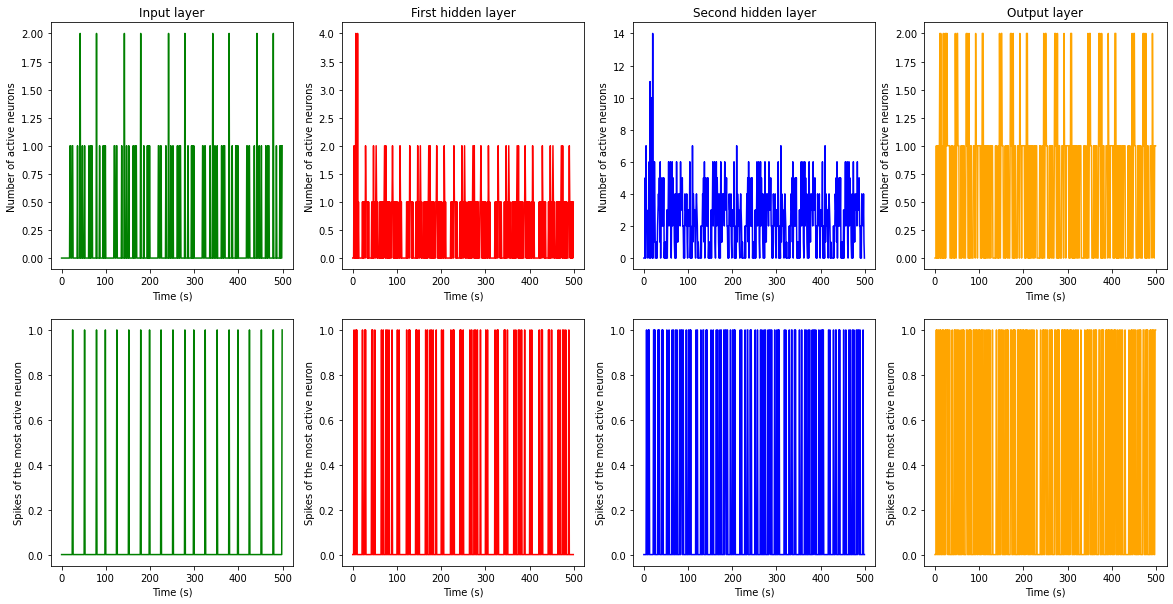

In [8]:
input_pattern3 = spike_train_generator(T, input_neurons, lam)

model3 = SRM(input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max)
for epoch in range(epochs):
  for tick in range(T):
    model3.apply(input_pattern3[tick], epoch * T + tick)

model3.visualize_simulation()

STDP (initial commit, check parameters)

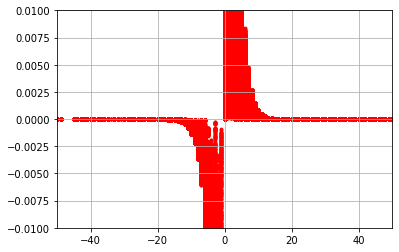

In [9]:
lam = 25
epochs = 5
T = 100
t_max = epochs * T

input_pattern4 = spike_train_generator(T, input_neurons, lam)

model4 = SRM(input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max)
for epoch in range(epochs):
  for tick in range(T):
    model4.apply(input_pattern4[tick], epoch * T + tick)
    model4.STDP(0, 1, 1.7, 2.0, 0.3, 0.2, tick)

model4.visualize_learning()

Task 2 - Simulation 4 - STDP on MNIST dataset

Pictures processing

In [10]:
def get_train_data():
    train_df = pd.read_csv("mnist_train.psv", sep="|", header=None)
    train_arr = train_df.to_numpy()
    return train_arr[:100, 1:], train_arr[:100, 0]


def get_test_data():
    test_df = pd.read_csv("mnist_test.psv", sep="|", header=None)
    test_arr = test_df.to_numpy()
    return test_arr[:50, 1:], test_arr[:50, 0]


def convert_MNIST_image_to_spikes_in_time(data, T):
    assert len(data) == 256

    res = np.zeros((T, 256))
    for i in range(256):
        pixel_intensity = data[i]
        lam = 1 + T * (1 - (pixel_intensity + 1) / 2.0)

        j = -1
        while j < T:
            j += np.random.poisson(lam, 1)
            if j >= T:
                break
            res[j, i] = 1

    return res

In [11]:
train_X, train_y = get_train_data()
test_X, test_y = get_test_data()

Parameters

In [12]:
input_neurons = 256
hidden_neurons_1 = 128
hidden_neurons_2 = 64
output_neurons = 10
min_synapses = 3
max_synapses = 7
max_delay = 7
threshold = 0.3
epochs = len(train_y)
T = 10
t_max = epochs * T

In [ ]:
model5 = SRM(input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max)
for epoch in range(epochs):
  input_pattern = convert_MNIST_image_to_spikes_in_time(train_X[epoch], T)
  target = int(train_y[epoch])
  for tick in tqdm(range(T)):
    cur_time = epoch * T + tick
    model5.apply(input_pattern[tick], cur_time)
    model5.STDP(0, 1, 1.7, 2.0, 0.3, 0.2, tick)

model5.visualize_learning()

Task 3 - Simulation 5 - STDP with reward (supervised)

In [ ]:
model6 = SRM(input_neurons, hidden_neurons_1, hidden_neurons_2, output_neurons, min_synapses, max_synapses, max_delay, threshold, t_max)
for epoch in range(epochs):
  input_pattern = convert_MNIST_image_to_spikes_in_time(train_X[epoch], T)
  target = int(train_y[epoch])
  for tick in tqdm(range(T)):
    cur_time = epoch * T + tick
    model6.apply(input_pattern[tick], cur_time)
    model6.calculate_reward(cur_time, target, 1.15, 5)
    model6.STDP(0, 1, 1.7, 2.0, 0.3, 0.2, tick)
  model6.reset_reward(epoch * (T + 1) - 1)

model6.visualize_learning()

Accuracy check

In [17]:
acc_sum = 0
for test_idx in range(len(test_y)):
    input_pattern = convert_MNIST_image_to_spikes_in_time(test_X[test_idx], T)
    target = int(test_y[test_idx])

    for tick in range(T):
        model6.apply(input_pattern[tick], tick)
        if is_target_spiking(model6.spikes_3[tick], target):
            acc_sum += 1
accuracy = acc_sum / (t_max)
print(accuracy)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in exp
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


0.35


Итоговая точность - 35%. Это можно объяснить малой выборкой для обучения (на большую не хватило оперативной памяти). Потенциально при увеличении обучающего массива можно добиться лучшей точности.